# Linear Model Selection and Regularisation

In [32]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import BaseEstimator
from functools import partial


**1. Forward and backward stepwise regression with simulated data**

*(a) Create a random number generator and use its `normal()` method to generate a predictor X of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.*

In [33]:
X = np.random.randn(100)
e = np.random.randn(100)

X.shape, e.shape

((100,), (100,))

*(b) Generate a response vector $Y$ of length $n = 100$ according to the model*

$$
Y = \beta_{0} +\beta_{1}X + \beta_{2}X^{2} + \beta_{3}X_{3} + \epsilon
$$

Where $\beta_{0} +\beta_{1} + \beta_{2} + \beta_{3}$ are constants of your choice

In [34]:
y = 2 + 7*X - 2*X**2 + 1/2 * X**3 + e

y.shape

(100,)

*(c) Use forward stepwise selection in order to select a model containing the predictors $X,X_{2}, . . . ,X_{10}$. What is the model obtained according to $C_{p}$? Report the coefficients of the model obtained.*

Firstly, $C_{p}$ is not a metric in sklearn or statsmodel, so we will write a function to calculate this. For a fitted least squares model with $d$ predictors, the $C_{p}$ estimate of the test MSE is computed by,

$$
C_{p} = \frac{1}{n}(RSS + 2d\hat{\sigma}^{2})
$$

Where $\hat{\sigma}^{2}$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement.

In [87]:
def nCp(sigma2:float, estimator:BaseEstimator, X:np.ndarray, y:np.ndarray) -> float:
    """
    negative Cp statistic
    """
    n, p = X.shape
    yhat = estimator.predict(X)
    rss = np.sum((y - yhat)**2)
    return -(rss + 2 * p * sigma2)/n

There is also no built in functionality for performing stepwise regression in sklearn. We will write a function to perform forward stepwise selection to select a model.

In [115]:
def forward_stepwise_regression(X:np.ndarray, y:np.ndarray, scoring_func:callable):
    """
    Performs forward stepwise regression based on the scoring function passed.
    Forward stepwise regression starts with the null model and sequentially adds
    predictors, selecting only the best performing model with at each stage.
    Performance is defined by the return value of the scoring_func argument passed to the model.
    Forward stepwise seeks to maximise the scoring function.

    The function returns the an array containing the column indexes of the best predictors
    """
    best_score = -float('inf')
    best_predictors = []
    continue_search = True

    while continue_search:
        predictor_used = None
        for p in range(X.shape[1]):
            if p not in best_predictors:
                X_current = sm.add_constant(X[:, best_predictors + [p]])
                model = sm.OLS(y, X_current).fit()
                score = scoring_func(model, X_current, y)

                if score > best_score:
                    best_score = score
                    predictor_used = p
        
        if predictor_used is None:
            continue_search = False
        else:
            best_predictors.append(predictor_used)

    
    return best_predictors

The parameter $\sigma^{2}$ used to calculate the $C_{p}$ statistic is usually estimated using the full model containing all of the predictors. Lets calculate this and freeze its value in a new partial object

first lets create the full set of predictors

In [96]:
X_full = np.power.outer(X, range(1, 11))
X_full.shape

(100, 10)

Now fit the full model

In [97]:
X_full_wconstant = sm.add_constant(X_full)
full_model = sm.OLS(y, X_full_wconstant).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     857.2
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           6.53e-84
Time:                        14:52:16   Log-Likelihood:                -137.20
No. Observations:                 100   AIC:                             296.4
Df Residuals:                      89   BIC:                             325.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1051      0.218      9.637      0.000       1.671       2.539
x1             7.6781      0.550     13.966      0.000       6.586       8.770
x2            -1.6542      1.306     -1.266      0.209      -4.250       0.942
x3            -0.1036      1.238     -0.084      0.934      -2.564       2.357
x4            -0.6888      1.926     -0.358      0.721      -4.516       3.138
x5             0.0491      0.797      0.062      0.951      -1.534       1.632
x6             0.4023      0.987      0.408      0.684      -1.558       2.363
x7             0.0050      0.183      0.027      0.978      -0.358       0.368
x8            -0.0753      0.187     -0.403      0.688      -0.446       0.296
x9          8.715e-05      0.015      0.006      0.995      -0.029       0.029
x10            0.0042      0.011      0.371      0.712      -0.018       0.027
==============================================================================
Omnibus:                        0.152   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.927   Jarque-Bera (JB):                0.014
Skew:                           0.026   Prob(JB):                        0.993
Kurtosis:                       3.024   Cond. No.                     3.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The scale property of the full model is the estimate $\sigma^{2}$. Now we create this variable and use it to freeze the Cp function and create a partial object 

In [98]:
sigma2 = full_model.scale
print(sigma2)
nCp_frozen = partial(nCp, sigma2)

1.0229993650661822


This partial object can now be used as the scoring function in our forward stepwise regression function

In [107]:
fsr_predictors = forward_stepwise_regression(X_full, y, nCp_frozen)
fsr_predictors

[0, 3, 1, 4]

Forward stepwise regression selected the following predictors $X, X^{4}, X^{2}, X^{5}$ The coefficients are reported below.

In [113]:
selected_predictors_df = pd.DataFrame(data=sm.add_constant(X_full[:, fsr_predictors]), columns=['Const', 'X', 'X4', 'X2', 'X5'])
fsr_model = sm.OLS(y, selected_predictors_df).fit()
fsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2229.
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           5.89e-93
Time:                        15:01:15   Log-Likelihood:                -138.49
No. Observations:                 100   AIC:                             287.0
Df Residuals:                      95   BIC:                             300.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          2.1443      0.145     14.791      0.000       1.856       2.432
X              7.6372      0.130     58.724      0.000       7.379       7.895
X4             0.0292      0.032      0.901      0.370      -0.035       0.093
X2            -2.0395      0.196    -10.395      0.000      -2.429      -1.650
X5             0.0531      0.006      8.813      0.000       0.041       0.065
==============================================================================
Omnibus:                        0.008   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.111
Skew:                           0.016   Prob(JB):                        0.946
Kurtosis:                       2.840   Cond. No.                         92.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*(d) Now do the same but use backward stepwise regression*

Again there is no implementation of backward stepwise regression so we will write a function to handle this.

In [131]:
def backward_stepwise_regression(X:np.ndarray, y:np.ndarray, scoring_func:callable):
    """
    Performs backward stepwise regression based on the scoring function passed.
    Backward stepwise regression starts with the full model and sequentially removes
    predictors, selecting only the best performing model with at each stage.
    Performance is defined by the return value of the scoring_func argument passed to the model.
    Backward stepwise seeks to maximise the scoring function.

    The function returns the an array containing the column indexes of the best predictors
    """
    full_model = sm.OLS(y, sm.add_constant(X)).fit()
    best_score = scoring_func(full_model, sm.add_constant(X), y)
    best_predictors = [i for i in range(X.shape[1])]
    continue_search = True
    
    while continue_search:
        predictor_removed = None
        for p in range(X.shape[1]):
            if p in best_predictors:
                X_currrent = sm.add_constant(X[:, [i for i in best_predictors if i != p]])
                model = sm.OLS(y, X_currrent).fit()
                score = scoring_func(model, X_currrent, y)

                if score > best_score:
                    best_score = score
                    predictor_removed = p
        
        if predictor_removed is None:
            continue_search = False

        else:
            best_predictors.remove(predictor_removed)
    
    return best_predictors



            
    

We can run backward stepwise regression

In [132]:
bsr_predictors = backward_stepwise_regression(X_full, y, nCp_frozen)
bsr_predictors

[0, 1, 5, 6, 7, 9]

In [136]:
bsr_selected_predictors = pd.DataFrame(data=sm.add_constant(X_full[:, bsr_predictors]), columns=['Const', 'X', 'X2', 'X6', 'X7', 'X8', 'X10'])
bsr_model = sm.OLS(y, bsr_selected_predictors).fit()
bsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sat, 13 Jul 2024   Prob (F-statistic):           5.38e-90
Time:                        08:58:14   Log-Likelihood:                -137.52
No. Observations:                 100   AIC:                             289.0
Df Residuals:                      93   BIC:                             307.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          2.1896      0.161     13.604      0.000       1.870       2.509
X              7.6282      0.139     55.027      0.000       7.353       7.903
X2            -2.2557      0.297     -7.604      0.000      -2.845      -1.667
X6             0.1497      0.087      1.719      0.089      -0.023       0.323
X7             0.0109      0.002      6.320      0.000       0.007       0.014
X8            -0.0402      0.021     -1.876      0.064      -0.083       0.002
X10            0.0027      0.001      2.061      0.042    9.81e-05       0.005
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.036
Skew:                          -0.020   Prob(JB):                        0.982
Kurtosis:                       2.917   Cond. No.                     4.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*(e) Now fit a lasso model agaisnt the simulated data. Use cross-validation to select the optimal $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the coefficient estimates and discuss the results obtained.*

We can fit a lasso model with cross validation using the `sklearn.ElasticNetCV()` function. Furthermore, it is important to standardise the predictors when fitting a lasso model. To scale the predictors we can use the `StandardScaler()` object provided by sklearn. Finally, we can package up feature preprocessing and model fitting into a single object by using sklearns `Pipeline()` object.

In [138]:
scaler = StandardScaler(with_mean=True, with_std=True)
lambdas = 10**np.linspace(8, -2, 100) / y.std()
lasso_cv = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=5)
pipeline = Pipeline(steps=[('scaler', scaler), ('lasso', lasso_cv)])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([1.06234557e+07, 8.41890700e+06, 6.67183982e+06, 5.28731896e+06,
       4.19010985e+06, 3.32059040e+06, 2.63151110e+06, 2.08542755e+06,
       1.65266567e+06, 1.30970928e+06, 1.03792220e+06, 8.22535597e+05,
       6.51845394e+05, 5.16576327e+05, 4.09377905e+05, 3.24424988e+05,
       2.57101255e+05, 2.03748348e+05,...
       2.23613560e-01, 1.77209922e-01, 1.40435833e-01, 1.11292996e-01,
       8.81977959e-02, 6.98952449e-02, 5.53907863e-02, 4.38962509e-02,
       3.47870281e-02, 2.75681249e-02, 2.18472675e-02, 1.73135859e-02,
       1.37207207e-02, 1.08734365e-02, 8.61701248e-03, 6.82883503e-03,
       5.41173497e-03, 4.28870742e-03, 3.39872728e-03, 2.69343325e-03,
       2.13449979e-03, 1.69155458e-03, 1.34052808e-03, 1.06234557e-03]),
                              cv=5, l1_ratio=1))])

In [141]:
pipeline.fit(sm.add_constant(X_full), y)
tuned_lasso = pipeline.named_steps['lasso']


c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9413994376839412, tolerance: 0.719078687713134
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6338278297445896, tolerance: 0.719078687713134
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.25256268059114, tolerance: 0.7652816610686924
  

We plot the cv error as a function of the $-log(\lambda)$ which has shrinkage decreasing from left to right. We can see the optimal value of $\lambda$ plotted on the chart. Also note that for a large range of $\lambda$ values the same model is fit - this is the straight horizontal line on the chart. Here the shrinkage parameter is too large which results in the null model always being fit.

Text(0.5, 0, '$-log(\\lambda)$')

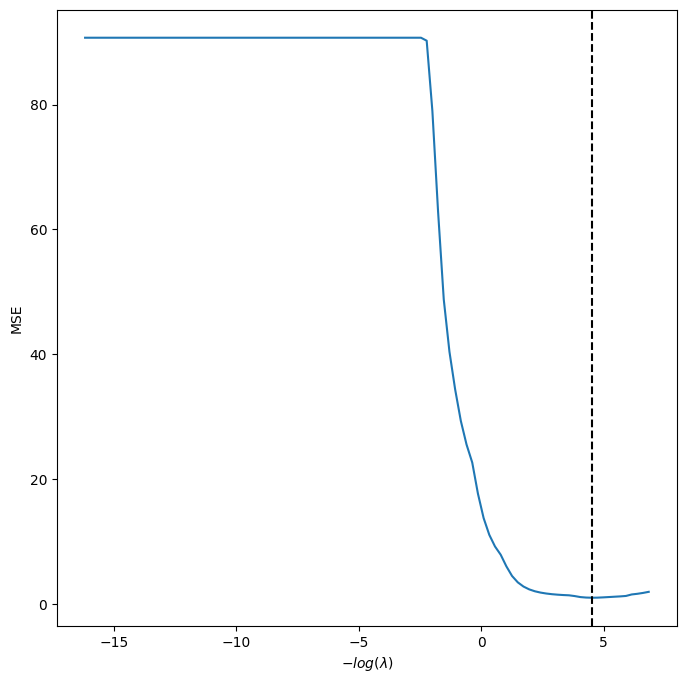

In [146]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylabel('MSE')
ax.set_xlabel(r'$-log(\lambda)$')

Lets have a look at the coefficient estimates of the lasso model

In [159]:
lasso_coefs = pd.Series(data=tuned_lasso.coef_.T, index=['Const', 'X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
lasso_coefs

Const    0.000000
X        7.118676
X2      -2.840373
X3       0.790322
X4      -0.000000
X5       1.207820
X6      -0.000000
X7       0.000000
X8      -0.000000
X9       0.000000
X10     -0.000000
dtype: float64

We can see that many of the coefficient estimates have been shrunk to 0. Furthermore, the lasso has correctly identified all of the predictors that have a relationship with response (except the intercept), it has incorrectly identified $X_{5}$ as being a significant predictor 

*(f) Now generate a response vector $Y$ according to the model*

$$
Y = \beta_{0} + \beta_{7}X^{7} + \epsilon
$$

Perform forward stepwise selection and the lasso. Discuss the results obtained

In [162]:
y = 5 + 2*X**7 + e

y.shape

(100,)